In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.insert(0, '../src')

from pathlib import Path
import pandas as pd
from zipfile import ZipFile
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from models import run_model_dep_classification, append_df_metrics, append_df_importances, create_df_importances
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from models import classification_metrics
import copy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

PNS_DATA = Path('../data/processed/PNS_2019/all.zip').resolve()
zip_pns = ZipFile(PNS_DATA)
df = pd.read_csv(zip_pns.open(zip_pns.namelist()[0]), sep=",", low_memory=False)

PATH_GEN_DATA = Path('generated_data/pns_data_models').resolve()

# Criação das variaveis de interesse

#### Label

In [2]:
# Target
df['depression'] = np.where(df['phq9_total'].isna(), np.nan, np.where(df['phq9_total'] >= 10, 1, 0))
df = df.dropna(subset=['depression'])
df['depression'].value_counts()

depression
0.0    58451
1.0     6949
Name: count, dtype: int64

#### Features derivadas

In [3]:
# Alimentos in natura ou minimamente processado
innatura = ['P00601','P00602', 'P00603', 'P00604', 'P00605', 'P00607', 'P00608', 'P00609', 'P00610', 'P00611', 'P00612', 'P00613']
df_innatura = df[innatura]
df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
# Alimentos ultraprocessados
ultraprocessados = ['P00614', 'P00615', 'P00616', 'P00617', 'P00618', 'P00619', 'P00620', 'P00621', 'P00622', 'P00623']
df_upf = df[ultraprocessados]
df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)

# A literatura não usa a porcentagem de ultraprocessados do prato como análise. O artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
# Usa como base o número de perguntas respondidas 'Sim' nos alimentos ultraprocessados das ultimas 24hrs
df['per_innatura'] = df_innatura['qst_innatura'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['per_upf'] = df_upf['qst_upf'] / (df_innatura['qst_innatura'] + df_upf['qst_upf']) * 100
df['qst_upf'] = df_upf['qst_upf'] # Baseado no artigo

def classify_upf(row):
    value = row['qst_upf']

    if  0 <= value < 2:
        return 1
    elif value < 4:
        return 2
    elif value < 6:
        return 3
    elif value < 8:
        return 4
    elif value <= 10:
        return 5

    return np.nan # questionario não respondido

df['upf_severity'] = df.apply(classify_upf, axis=1)


def count_imc(row):
    height = row['altura']
    weight = row['peso']

    imc = weight/np.square(height/100)   # Peso está em kg e altura em cm, no calculo do imc é kg/m^2
    return imc

df['imc'] = df.apply(count_imc, axis=1)


def classify_imc(row):
    value = row['imc']

    if  0 <= value < 18.5:
        return 1  # Baixo peso
    elif value < 24.9:
        return 2 # Eutrofia/peso adequado
    elif value < 29.9:
        return 3   # Sobrepeso
    elif value >= 30:
        return 4  # Obesidade

    return np.nan # questionario não respondido

df['class_imc'] = df.apply(classify_imc, axis=1)


def classify_idade(row):
    value = row['idade']
    if  20 <= value <= 29:
        return 1
    elif value <= 39:
        return 2
    elif value <= 49:
        return 3
    elif value <= 59:
        return 4

    return np.nan

df['class_idade'] = df.apply(classify_idade, axis=1)


# Essa variável foi criada a partir de um índice utilizado pela OMS. Na literatura, usam a pergunta 'P034' relacionada à prática de exercícios físicos nos ultimos 3 meses
df_activity = pd.DataFrame()
df_activity['minutes_per_week'] = df['P03702'] * df['P035']

vigorous_activities = [3.0, 4.0, 5.0, 6.0, 12.0, 13.0, 15.0]
moderated_activities = [1.0, 2.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 16.0, 17.0]
df_activity['time_vigorous'] = df_activity['minutes_per_week'].loc[df['P036'].isin(vigorous_activities)]
df_activity['time_moderated'] = df_activity['minutes_per_week'].loc[df['P036'].isin(moderated_activities)]

df_activity['activity_class'] = 0
df_activity.loc[df_activity['minutes_per_week'].isna(), 'activity_class'] = np.nan
df_activity.loc[(df_activity['time_vigorous'] >= 75) | (df_activity['time_moderated'] >= 150), 'activity_class'] = 1

df['activity_class'] = df_activity['activity_class']
df['exerc_fisico'] = np.where(df['P034'].isin([1.0]), 1, np.where(df['P034'] == 2.0, 0, np.nan))
df['tabagismo'] = np.where(df['P050'].isin([1.0, 2.0]), 1, np.where(df['P050'] == 3.0, 0, np.nan))

# Na literatura eles usam outra variável para analisar o consumo alcoolico
df['cons_alcool'] = np.where(df['P02801'] >= 1, 1, 0)
df['cons_alcool'] = np.where(df['P02801'].isna(), np.nan, df['cons_alcool'])

# Olhar artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df['cons_alcool'] = np.where(df['P027'].isin([2.0, 3.0]), 1, np.where(df['P027'] == 1.0, 0, np.nan))

df = df[df['P005'] != 1.0] #Retirando as grávidas da análise

df['obesidade'] = np.where(df['class_imc'].isna(), np.nan, np.where(df['class_imc'] >= 4, 1, 0))

# Limitação da análise por idades que se adequam ao PHQ9 baseado no artigo 'Food consumption and depression among Brazilian adults: results from the Brazilian National Health Survey, 2013'
df = df[(df['idade'] >= 20) & (df['idade'] <= 59)]

/tmp/ipykernel_25307/998047707.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_innatura['qst_innatura'] = (df_innatura == 1.0).sum(axis=1)
/tmp/ipykernel_25307/998047707.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_upf['qst_upf'] = (df_upf == 1.0).sum(axis=1)


In [4]:
df['depression'].value_counts()

depression
0.0    56057
1.0     6650
Name: count, dtype: int64

# Análise de dados faltantes

#### População total

In [5]:
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', df['Q092'].isna().sum(), 'Perc:',  round(df['Q092'].isna().sum()/len(df['Q092'])*100, 3))
print('Faltantes em PHQ9_total - classificação de grau de depressão: ', df['phq9_total'].isna().sum(), 'Perc:',  round(df['phq9_total'].isna().sum()/len(df['phq9_total'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', df['vive_conjugue'].isna().sum(), 'Perc:',  round(df['vive_conjugue'].isna().sum()/len(df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', df['class_idade'].isna().sum(), 'Perc:',  round(df['class_idade'].isna().sum()/len(df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', df['cor'].isna().sum(), 'Perc:',  round(df['cor'].isna().sum()/len(df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', df['upf_severity'].isna().sum(), 'Perc:',  round(df['upf_severity'].isna().sum()/len(df['upf_severity'])*100, 3))
print('Faltantes em exerc_fisico - classificação de atividade física: ', df['exerc_fisico'].isna().sum(), 'Perc:',  round(df['exerc_fisico'].isna().sum()/len(df['exerc_fisico'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', df['tabagismo'].isna().sum(), 'Perc:',  round(df['tabagismo'].isna().sum()/len(df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - classificação do consumo de álcool: ', df['cons_alcool'].isna().sum(), 'Perc:',  round(df['cons_alcool'].isna().sum()/len(df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', df['Q120'].isna().sum(), 'Perc:',  round(df['Q120'].isna().sum()/len(df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', df['Q00201'].isna().sum(), 'Perc:',  round(df['Q00201'].isna().sum()/len(df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', df['Q03001'].isna().sum(), 'Perc:',  round(df['Q03001'].isna().sum()/len(df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', df['Q06306'].isna().sum(), 'Perc:',  round(df['Q06306'].isna().sum()/len(df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', df['Q060'].isna().sum(), 'Perc:',  round(df['Q060'].isna().sum()/len(df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', df['Q068'].isna().sum(), 'Perc:',  round(df['Q068'].isna().sum()/len(df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', df['Q079'].isna().sum(), 'Perc:',  round(df['Q079'].isna().sum()/len(df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', df['class_imc'].isna().sum(), 'Perc:',  round(df['class_imc'].isna().sum()/len(df['class_imc'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em PHQ9_total - classificação de grau de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em exerc_fisico - classificação de atividade física:  0 Perc: 0.0
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - classificação do consumo de álcool:  0 Perc: 0.0
Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  1295 Perc: 2.065
Faltantes em Q03001 - diagnostico diabetes:  5014 Perc: 7.996
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  5897 Perc: 9.404
Faltantes em Q068 - diagno

## População considerada depressiva (PHQ9>=10)

In [6]:
new_df = df[df['phq9_total'] >= 10].copy()
print('Faltantes em Q092 - pergunta do diagnóstico de depressão: ', new_df['Q092'].isna().sum(), 'Perc:',  round(new_df['Q092'].isna().sum()/len(new_df['Q092'])*100, 3))
print('Faltantes em vive_conjugue - classificação do estado civil: ', new_df['vive_conjugue'].isna().sum(), 'Perc:',  round(new_df['vive_conjugue'].isna().sum()/len(new_df['vive_conjugue'])*100, 3))
print('Faltantes em class_idade - classificação de idade: ', new_df['class_idade'].isna().sum(), 'Perc:',  round(new_df['class_idade'].isna().sum()/len(new_df['class_idade'])*100, 3))
print('Faltantes em cor - cor ou raça autodeclaradas: ', new_df['cor'].isna().sum(), 'Perc:',  round(new_df['cor'].isna().sum()/len(new_df['cor'])*100, 3))

print('Faltantes em UPF_severity - classificação de consumo de ultraprocessados: ', new_df['upf_severity'].isna().sum(), 'Perc:',  round(new_df['upf_severity'].isna().sum()/len(new_df['upf_severity'])*100, 3))
print('Faltantes em activity_class - classificação de atividade física: ', new_df['activity_class'].isna().sum(), 'Perc:',  round(new_df['activity_class'].isna().sum()/len(new_df['activity_class'])*100, 3))
print('Faltantes em tabagist - classificação de tabagismo: ', new_df['tabagismo'].isna().sum(), 'Perc:',  round(new_df['tabagismo'].isna().sum()/len(new_df['tabagismo'])*100, 3))
print('Faltantes em cons_alcool - clasificação do consumo de álcool: ', new_df['cons_alcool'].isna().sum(), 'Perc:',  round(new_df['cons_alcool'].isna().sum()/len(new_df['cons_alcool'])*100, 3))

print('Faltantes em Q120 - pergunta do diagnóstico de cancer: ', new_df['Q120'].isna().sum(), 'Perc:',  round(new_df['Q120'].isna().sum()/len(new_df['Q120'])*100, 3))
print('Faltantes em Q00201 - diagnotisco pressão alta: ', new_df['Q00201'].isna().sum(), 'Perc:',  round(new_df['Q00201'].isna().sum()/len(new_df['Q00201'])*100, 3))
print('Faltantes em Q03001 - diagnostico diabetes: ', new_df['Q03001'].isna().sum(), 'Perc:',  round(new_df['Q03001'].isna().sum()/len(new_df['Q03001'])*100, 3))
print('Faltantes em Q06306 - diagnostico cardiovascular : ', new_df['Q06306'].isna().sum(), 'Perc:',  round(new_df['Q06306'].isna().sum()/len(new_df['Q06306'])*100, 3))
print('Faltantes em Q060 - diagnostico colesterol alto: ', new_df['Q060'].isna().sum(), 'Perc:',  round(new_df['Q060'].isna().sum()/len(new_df['Q060'])*100, 3))
print('Faltantes em Q068 - diagnostico de AVC: ', new_df['Q068'].isna().sum(), 'Perc:',  round(new_df['Q068'].isna().sum()/len(new_df['Q068'])*100, 3))
print('Faltantes em Q079 - diagnostico de artrite: ', new_df['Q079'].isna().sum(), 'Perc:',  round(new_df['Q079'].isna().sum()/len(new_df['Q079'])*100, 3))
print('Faltantes em class_imc - classificação de imc: ', new_df['class_imc'].isna().sum(), 'Perc:',  round(new_df['class_imc'].isna().sum()/len(new_df['class_imc'])*100, 3))

Faltantes em Q092 - pergunta do diagnóstico de depressão:  0 Perc: 0.0
Faltantes em vive_conjugue - classificação do estado civil:  0 Perc: 0.0
Faltantes em class_idade - classificação de idade:  0 Perc: 0.0
Faltantes em cor - cor ou raça autodeclaradas:  0 Perc: 0.0
Faltantes em UPF_severity - classificação de consumo de ultraprocessados:  0 Perc: 0.0
Faltantes em activity_class - classificação de atividade física:  4470 Perc: 67.218
Faltantes em tabagist - classificação de tabagismo:  0 Perc: 0.0
Faltantes em cons_alcool - clasificação do consumo de álcool:  0 Perc: 0.0
Faltantes em Q120 - pergunta do diagnóstico de cancer:  0 Perc: 0.0
Faltantes em Q00201 - diagnotisco pressão alta:  58 Perc: 0.872
Faltantes em Q03001 - diagnostico diabetes:  316 Perc: 4.752
Faltantes em Q06306 - diagnostico cardiovascular :  0 Perc: 0.0
Faltantes em Q060 - diagnostico colesterol alto:  401 Perc: 6.03
Faltantes em Q068 - diagnostico de AVC:  0 Perc: 0.0
Faltantes em Q079 - diagnostico de artrite:  0

# Modelos

In [7]:
df_metrics_all = pd.DataFrame()
df_importances_all = pd.DataFrame()

### Seleção das variaveis e ajustes

In [8]:
df_total = pd.DataFrame()

df_total['exerc_fisico'] = df['exerc_fisico']
df_total['tabagismo'] = df['tabagismo']
df_total['cons_alcool'] = df['cons_alcool']
df_total['cancer'] = df['Q120']
df_total['hipertensao'] = df['Q00201']
df_total['diabetes'] = df['Q03001']
df_total['cardiovascular'] = df['Q06306']
df_total['hipercolesterolemia'] = df['Q060']
df_total['avc'] = df['Q068']
df_total['artrite'] = df['Q079']
df_total['obesidade'] = df['obesidade']
df_total['depression'] = df['depression']
df_total['sexo'] = df['sexo']
df_total['estado_civil'] = df['vive_conjugue']
df_total = df_total.replace(2.0, 0.0)
df_total['escolaridade'] = df['escolaridade_agregada']
df_total['upf'] = df['qst_upf']
df_total['class_idade'] = df['class_idade']
df_total['cor_branca'] = np.where(df['cor'] == 1, 1, 0)
df_total['cor_preta'] = np.where(df['cor'] == 2, 1, 0)
df_total['cor_amarela'] = np.where(df['cor'] == 3, 1, 0)
df_total['cor_parda'] = np.where(df['cor'] == 4, 1, 0)
df_total['cor_indigena'] = np.where(df['cor'] == 5, 1, 0)
df_total['activity_class'] = df['activity_class']
df_total['renda_pc'] = df['renda_pc']

df_train_total, df_test_total = train_test_split(df_total, test_size=0.3, random_state=42)

### Modelo apenas com habitos

In [9]:
df_habitos = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'depression']].dropna()
X = df_habitos.drop('depression', axis=1)
y = df_habitos['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.554427,0.547683,0.008712,0.128737,0.127871,0.002649,0.558843,0.565106,0.026736,0.209267,0.208524,0.005198


,value
name,
intercept,0.074058
upf,0.041272
exerc_fisico,-0.323945
tabagismo,0.427500
cons_alcool,-0.264509


### Modelo apenas com as doenças cronicas

In [10]:
df_doencas = df_train_total[['cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()
X = df_doencas.drop('depression', axis=1)
y = df_doencas['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_dcnt')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.67404,0.700527,0.019018,0.170818,0.175308,0.0059,0.513341,0.467769,0.037702,0.256338,0.254613,0.008025


,value
name,
intercept,-0.356141
cancer,0.638008
hipertensao,0.378574
diabetes,0.367290
cardiovascular,0.751614
hipercolesterolemia,0.379810
avc,0.800662
artrite,0.986969
obesidade,0.136941


### Modelo com doenças e hábitos

In [11]:
df_total = df_train_total[['upf', 'exerc_fisico', 'tabagismo', 'cons_alcool', 'cancer', 'hipertensao', 'diabetes', 'cardiovascular', 'hipercolesterolemia', 'avc', 'artrite', 'obesidade', 'depression']].dropna()
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_habitos_dcnt')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_habitos_dcnt')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.692361,0.689777,0.003716,0.181108,0.179666,0.00519,0.514286,0.514522,0.015741,0.26788,0.266327,0.007744


,value
name,
intercept,-0.384639
upf,0.060392
exerc_fisico,-0.288793
tabagismo,0.462443
cons_alcool,-0.166574
cancer,0.651688
hipertensao,0.367602
diabetes,0.358883
cardiovascular,0.726210


### Modelo só com variáveis sociodemográficas

In [12]:
df_total = df_train_total[['sexo', 'estado_civil', 'escolaridade', 'class_idade', 'cor_branca', 'cor_preta', 'cor_amarela', 'cor_parda', 'cor_indigena', 'depression']].dropna()
X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_apenas_sociodemo')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_apenas_sociodemo')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.549305,0.548456,0.00909,0.153719,0.153536,0.002901,0.728963,0.729213,0.010199,0.253898,0.253649,0.004211


,value
name,
intercept,0.533035
sexo,-1.116056
estado_civil,-0.386312
escolaridade,-0.118837
class_idade,0.081474
cor_branca,0.082803
cor_preta,0.208799
cor_amarela,-0.095273
cor_parda,0.135226


### Modelo com todas as variáveis de interesse

#### Correlações

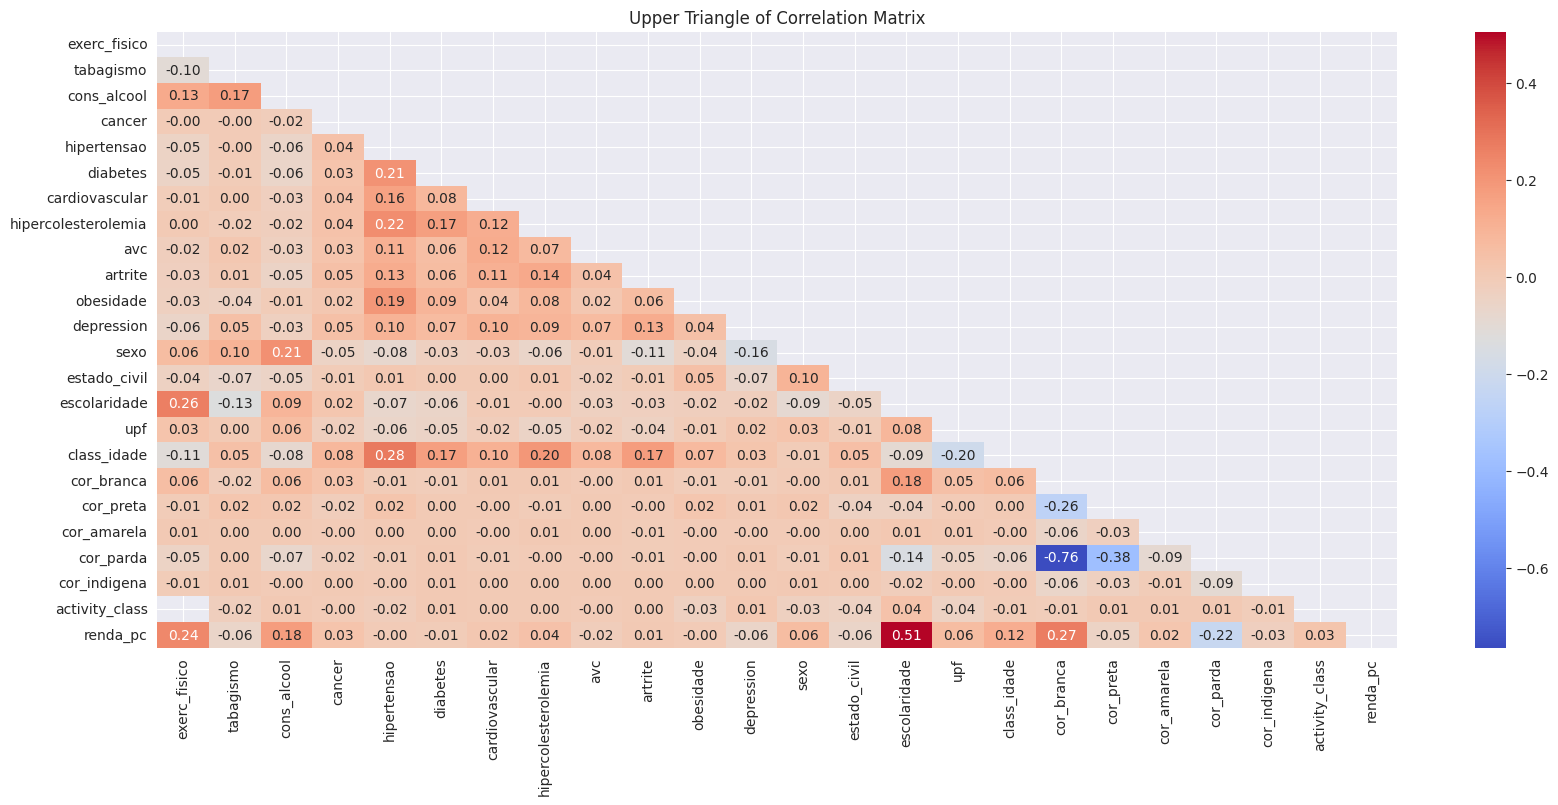

In [13]:
df_total = copy.deepcopy(df_train_total)

corr_matrix = df_total.corr()
correlations = corr_matrix['depression'].abs().sort_values(ascending=False)

mask = np.triu(np.ones(corr_matrix.shape)).astype(bool)
fig, ax = plt.subplots(figsize=(20, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", ax=ax)
ax.set_title("Upper Triangle of Correlation Matrix")
plt.show()

In [14]:
correlations.head(30)

depression             1.000000
sexo                   0.155725
artrite                0.127112
hipertensao            0.103099
cardiovascular         0.098903
hipercolesterolemia    0.092275
diabetes               0.067848
estado_civil           0.067589
avc                    0.066860
renda_pc               0.055832
exerc_fisico           0.055817
cancer                 0.047308
tabagismo              0.046630
obesidade              0.044563
cons_alcool            0.034509
class_idade            0.027255
escolaridade           0.022668
upf                    0.019194
cor_branca             0.013395
activity_class         0.011427
cor_preta              0.008380
cor_parda              0.007407
cor_amarela            0.003110
cor_indigena           0.002833
Name: depression, dtype: float64

#### Exluindo todos dados nulos

In [15]:
df_total = copy.deepcopy(df_train_total)
df_total = df_total.dropna()

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.coef_[0], model.intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_dropna')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_dropna')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.654523,0.654106,0.012284,0.151549,0.150685,0.008461,0.65749,0.652632,0.036786,0.246322,0.244796,0.013377


,value
name,
intercept,0.422426
exerc_fisico,0.361026
tabagismo,0.657350
cons_alcool,-0.109496
cancer,0.890233
hipertensao,0.424845
diabetes,0.458432
cardiovascular,0.555294
hipercolesterolemia,0.454610


#### Usando a média

In [16]:
df_total = copy.deepcopy(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_meanimp')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_meanimp')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.654395,0.652891,0.005419,0.183152,0.181921,0.00249,0.657741,0.654718,0.008292,0.286521,0.284715,0.003374


,value
name,
intercept,0.393043
exerc_fisico,-0.216890
tabagismo,0.522767
cons_alcool,0.004935
cancer,0.634283
hipertensao,0.416592
diabetes,0.396018
cardiovascular,0.811774
hipercolesterolemia,0.442387


### Testando SMOTE

In [17]:

# o SMOTE é uma possibilidade para podermos realizar data augmentation dos dados de pessoas consideradas depressivas
# O desbalanceio das classes é ENORME (~59k não depressivos e 7k depressivos)
# Ele olha a classe com menos quantidade de amostras e gera uma nova distribuição de acordo com as semelhanças entre vizinhos

df_total = copy.deepcopy(df_train_total)

X = df_total.drop('depression', axis=1)
y = df_total['depression']

model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('smt', SMOTE(sampling_strategy='auto', random_state=42)),
    ('reg', LogisticRegression(max_iter=1000, class_weight=None, random_state=42))
])

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_all_smote')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_all_smote')

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.620449,0.619424,0.005492,0.172395,0.171999,0.001923,0.683438,0.683438,0.004165,0.275337,0.274823,0.002381


,value
name,
intercept,0.434302
exerc_fisico,-0.285619
tabagismo,0.437555
cons_alcool,0.020655
cancer,0.336073
hipertensao,0.418627
diabetes,0.226858
cardiovascular,0.652645
hipercolesterolemia,0.328932


### Ajuste Hyper-parametro

In [18]:
df_total = copy.deepcopy(df_train_total)

model = LogisticRegression(class_weight='balanced')

X = df_total.drop('depression', axis=1)
y = df_total['depression']

param_grid = {
    'imp__strategy': ['mean', 'median'],
    'reg__C': [0.1, 1.0, 10.0],
    'reg__solver': ['liblinear', 'saga'],
    'reg__max_iter': [100, 500, 1000]
}


model = Pipeline([
    ('imp', SimpleImputer(missing_values=np.nan, strategy='mean')),
    ('reg', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)
model = grid_search.best_estimator_
print("Best params: ")
print(grid_search.best_params_)

model, df_metrics = run_model_dep_classification(model, X, y)
df_importances = create_df_importances(X.columns, model.named_steps['reg'].coef_[0],  model.named_steps['reg'].intercept_[0])

display(df_metrics)
display(df_importances)

df_metrics_all = append_df_metrics(df_metrics_all, df_metrics, 'log_best_grid')
df_importances_all = append_df_importances(df_importances_all, df_importances, 'log_best_grid')

/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/anderson/.local/lib/python3.10/site-packages/sklearn/linear_mode

Best params: 
{'imp__strategy': 'median', 'reg__C': 0.1, 'reg__max_iter': 100, 'reg__solver': 'liblinear'}


exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
0,0.655374,0.654076,0.005548,0.183741,0.18238,0.002483,0.658389,0.65407,0.006936,0.287303,0.285215,0.003229


,value
name,
intercept,0.406380
exerc_fisico,-0.219964
tabagismo,0.524204
cons_alcool,0.005148
cancer,0.602406
hipertensao,0.426959
diabetes,0.402430
cardiovascular,0.787541
hipercolesterolemia,0.457308


### Salvando/exibindo tabelas criadas

In [19]:
df_metrics_all.to_excel(PATH_GEN_DATA / 'metrics.xlsx')
df_metrics_all

exp,train_acc,test_acc,test_acc_std,train_precision,test_precision,test_precision_std,train_recall,test_recall,test_recall_std,train_f1,test_f1,test_f1_std
log_apenas_habitos,0.554427,0.547683,0.008712,0.128737,0.127871,0.002649,0.558843,0.565106,0.026736,0.209267,0.208524,0.005198
log_apenas_dcnt,0.674040,0.700527,0.019018,0.170818,0.175308,0.005900,0.513341,0.467769,0.037702,0.256338,0.254613,0.008025
log_apenas_habitos_dcnt,0.692361,0.689777,0.003716,0.181108,0.179666,0.005190,0.514286,0.514522,0.015741,0.267880,0.266327,0.007744
log_apenas_sociodemo,0.549305,0.548456,0.009090,0.153719,0.153536,0.002901,0.728963,0.729213,0.010199,0.253898,0.253649,0.004211
log_all_dropna,0.654523,0.654106,0.012284,0.151549,0.150685,0.008461,0.657490,0.652632,0.036786,0.246322,0.244796,0.013377
log_all_meanimp,0.654395,0.652891,0.005419,0.183152,0.181921,0.002490,0.657741,0.654718,0.008292,0.286521,0.284715,0.003374
log_all_smote,0.620449,0.619424,0.005492,0.172395,0.171999,0.001923,0.683438,0.683438,0.004165,0.275337,0.274823,0.002381
log_best_grid,0.655374,0.654076,0.005548,0.183741,0.182380,0.002483,0.658389,0.654070,0.006936,0.287303,0.285215,0.003229


In [20]:
df_importances_all.to_excel(PATH_GEN_DATA / 'importances.xlsx')
df_importances_all

,log_apenas_habitos,log_apenas_dcnt,log_apenas_habitos_dcnt,log_apenas_sociodemo,log_all_dropna,log_all_meanimp,log_all_smote,log_best_grid
name,,,,,,,,
intercept,0.074058,-0.356141,-0.384639,0.533035,0.422426,0.393043,0.434302,0.406380
upf,0.041272,NaN,0.060392,NaN,0.068111,0.066676,0.061626,0.066636
exerc_fisico,-0.323945,NaN,-0.288793,NaN,0.361026,-0.216890,-0.285619,-0.219964
tabagismo,0.427500,NaN,0.462443,NaN,0.657350,0.522767,0.437555,0.524204
cons_alcool,-0.264509,NaN,-0.166574,NaN,-0.109496,0.004935,0.020655,0.005148
cancer,NaN,0.638008,0.651688,NaN,0.890233,0.634283,0.336073,0.602406
hipertensao,NaN,0.378574,0.367602,NaN,0.424845,0.416592,0.418627,0.426959
diabetes,NaN,0.367290,0.358883,NaN,0.458432,0.396018,0.226858,0.402430
cardiovascular,NaN,0.751614,0.726210,NaN,0.555294,0.811774,0.652645,0.787541


### Resultado regressão linear

Treino


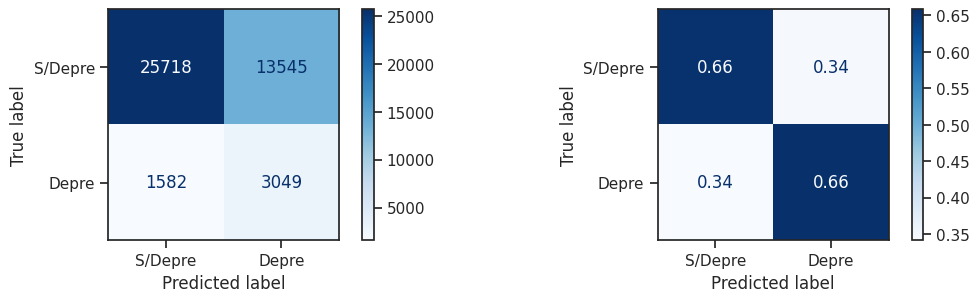

Teste


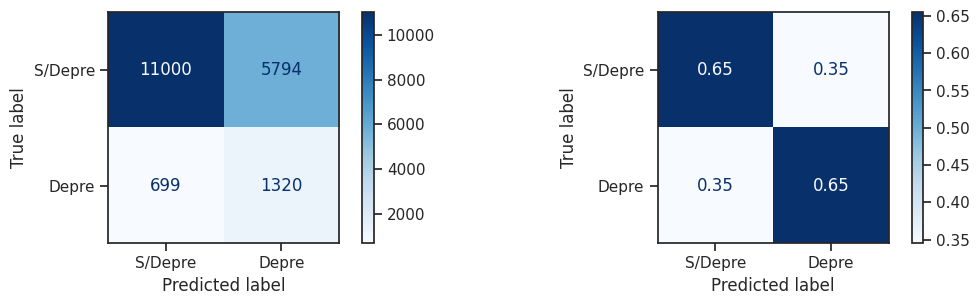

,accuracy_train,f1_score_train,precision_train,recall_train,accuracy_test,f1_score_test,precision_test,recall_test
0,0.655374,0.287303,0.183741,0.658389,0.654866,0.289062,0.18555,0.653789


In [21]:
print("Treino")
metrics_train = classification_metrics(model, X, y)

df_test = copy.deepcopy(df_test_total)
X_test = df_test.drop('depression', axis=1)
y_test = df_test['depression']

print("Teste")

metrics_test = classification_metrics(model, X_test, y_test)

metrics_train = {key + '_train': value for key, value in metrics_train.items()}
metrics_test = {key + '_test': value for key, value in metrics_test.items()}

df_metrics = pd.DataFrame([{**metrics_train, **metrics_test}])
df_metrics